In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

In [2]:
bigMartDf = pd.read_csv('bigdatamart_Train.csv')
bigMartDf.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [3]:
bigMartDf.shape

(8523, 12)

Our models has 8523 rows and 12 columns

In [4]:
bigMartDf.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are 1463 missing values in Item_Weight and 2410 missing values in Outlet_Size

In [5]:
bigMartDf.groupby(['Item_Identifier'])['Item_Weight'].mean()

Item_Identifier
DRA12    11.600
DRA24    19.350
DRA59     8.270
DRB01     7.390
DRB13     6.115
          ...  
NCZ30     6.590
NCZ41    19.850
NCZ42    10.500
NCZ53     9.600
NCZ54    14.650
Name: Item_Weight, Length: 1559, dtype: float64

In [6]:
bigMartDf[bigMartDf['Item_Identifier'] == 'FDA15']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
831,FDA15,9.3,Low Fat,0.016055,Dairy,250.2092,OUT045,2002,NaN,Tier 2,Supermarket Type1,5976.2208
2599,FDA15,9.3,Low Fat,0.016019,Dairy,248.5092,OUT035,2004,Small,Tier 2,Supermarket Type1,6474.2392
2643,FDA15,9.3,Low Fat,0.016088,Dairy,249.6092,OUT018,2009,Medium,Tier 3,Supermarket Type2,5976.2208
4874,FDA15,9.3,Low Fat,0.026818,Dairy,248.9092,OUT010,1998,NaN,Tier 3,Grocery Store,498.0184
5413,FDA15,9.3,Low Fat,0.016009,Dairy,250.6092,OUT013,1987,High,Tier 3,Supermarket Type1,6474.2392
6696,FDA15,NaN,Low Fat,0.015945,Dairy,249.5092,OUT027,1985,Medium,Tier 3,Supermarket Type3,6474.2392
7543,FDA15,9.3,LF,0.016113,Dairy,248.8092,OUT017,2007,NaN,Tier 2,Supermarket Type1,5976.2208


In [7]:
bigMartDf[bigMartDf['Item_Identifier'] == 'DRA12']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
118,DRA12,11.6,Low Fat,0.041178,Soft Drinks,140.3154,OUT017,2007,NaN,Tier 2,Supermarket Type1,2552.6772
1197,DRA12,11.6,Low Fat,0.000000,Soft Drinks,141.6154,OUT045,2002,NaN,Tier 2,Supermarket Type1,3829.0158
1245,DRA12,11.6,Low Fat,0.040912,Soft Drinks,142.3154,OUT013,1987,High,Tier 3,Supermarket Type1,2552.6772
1693,DRA12,11.6,LF,0.000000,Soft Drinks,141.9154,OUT035,2004,Small,Tier 2,Supermarket Type1,992.7078
7467,DRA12,11.6,Low Fat,0.041113,Soft Drinks,142.0154,OUT018,2009,Medium,Tier 3,Supermarket Type2,850.8924
8043,DRA12,11.6,Low Fat,0.068535,Soft Drinks,143.0154,OUT010,1998,NaN,Tier 3,Grocery Store,283.6308


By inspecting the two product identifier, we see that all products with the same identifier have the same exact weight. Therefore, for the missing values in the column 'Item_Weight', we will replace it with the weight of other Item_identifier of the same type.

In [10]:
#Making a copy of the bigMartDf and replacing the missing values in Item_Weight in the copy
bigMartDfCopy = bigMartDf.copy()

for index in range(len(bigMartDf['Item_Identifier'])):
    if bigMartDfCopy['Item_Weight'].isnull()[index]:
        bigMartDfCopy.loc[bigMartDfCopy['Item_Identifier'] == bigMartDfCopy['Item_Identifier'][index], 'Item_Weight'] = bigMartDf[bigMartDf['Item_Identifier'] == bigMartDfCopy['Item_Identifier'][index]]['Item_Weight'].median()

In [11]:
bigMartDfCopy.isnull().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

There are still 4 missing values in the Item_Weight column. Let us examine why.

In [12]:
bigMartDfCopy[bigMartDfCopy['Item_Weight'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [13]:
bigMartDf[bigMartDf['Item_Identifier'] == 'FDN52']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564


In [14]:
bigMartDf[bigMartDf['Item_Identifier'] == 'FDK57']

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.044,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.228


We see that for these four Item_Weight there was only one 'Item_Identifier' so the median did not get calculated and so it was left as blank while running in the for loop.

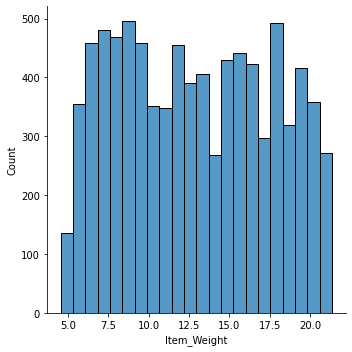

In [15]:
sns.displot(bigMartDfCopy['Item_Weight'])

Since the 'Item_Weight' column is not normally distributed, we will replace the four missing values in this column with the median of the entire column

In [16]:
bigMartDfCopy['Item_Weight'].fillna(bigMartDfCopy['Item_Weight'].median(), inplace = True)

In [17]:
#Now checking the missing values in Outlet_Size
bigMartDfCopy[bigMartDfCopy['Outlet_Size'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350
25,NCD06,13.000,Low Fat,0.099887,Household,45.9060,OUT017,2007,NaN,Tier 2,Supermarket Type1,838.9080
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
...,...,...,...,...,...,...,...,...,...,...,...,...
8502,NCH43,8.420,Low Fat,0.070712,Household,216.4192,OUT045,2002,NaN,Tier 2,Supermarket Type1,3020.0688
8508,FDW31,11.350,Regular,0.043246,Fruits and Vegetables,199.4742,OUT045,2002,NaN,Tier 2,Supermarket Type1,2587.9646
8509,FDG45,8.100,Low Fat,0.214306,Fruits and Vegetables,213.9902,OUT010,1998,NaN,Tier 3,Grocery Store,424.7804
8514,FDA01,15.000,Regular,0.054489,Canned,57.5904,OUT045,2002,NaN,Tier 2,Supermarket Type1,468.7232


In [18]:
bigMartDfCopy['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [19]:
#Since Outlet_Size is categorical column and the mode from above is 'Medium', we will replace all missing values under this column with 'Medium'
bigMartDfCopy['Outlet_Size'].fillna('Medium', inplace = True)

In [20]:
bigMartDf = bigMartDfCopy
bigMartDf.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [21]:
#Making list of categorical columns
categoricalCol = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']

In [22]:
#Printing the value counts for each categorical column for inspection
for index in range(len(categoricalCol)):
    print(f'{categoricalCol[index]}\n---------------\n{bigMartDf[categoricalCol[index]].value_counts()}\n--------------------\n')

Item_Identifier
---------------
FDG33    10
FDW13    10
FDW26     9
FDX31     9
FDU12     9
         ..
FDK57     1
FDT35     1
FDQ60     1
FDO33     1
FDN52     1
Name: Item_Identifier, Length: 1559, dtype: int64
--------------------

Item_Fat_Content
---------------
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64
--------------------

Item_Type
---------------
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64
--------------------

Outlet_Identifier
---------------


From the above output we see that for the column Item_Fat_Content, the entries 'Low Fat', 'low fat' and 'LF' indicate the same information, i.e, the product is a low fat product and entrie 'reg' and 'Regular' are also the same thing. Therefore, we will replace 'low fat' & 'LF' with 'Low Fat' and 'reg' with 'Regular' for consistency.

In [23]:
bigMartDf.loc[bigMartDf.Item_Fat_Content == 'low fat', 'Item_Fat_Content'] = 'Low Fat'
bigMartDf.loc[bigMartDf.Item_Fat_Content == 'LF', 'Item_Fat_Content'] = 'Low Fat'
bigMartDf.loc[bigMartDf.Item_Fat_Content == 'reg', 'Item_Fat_Content'] = 'Regular'
bigMartDf['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

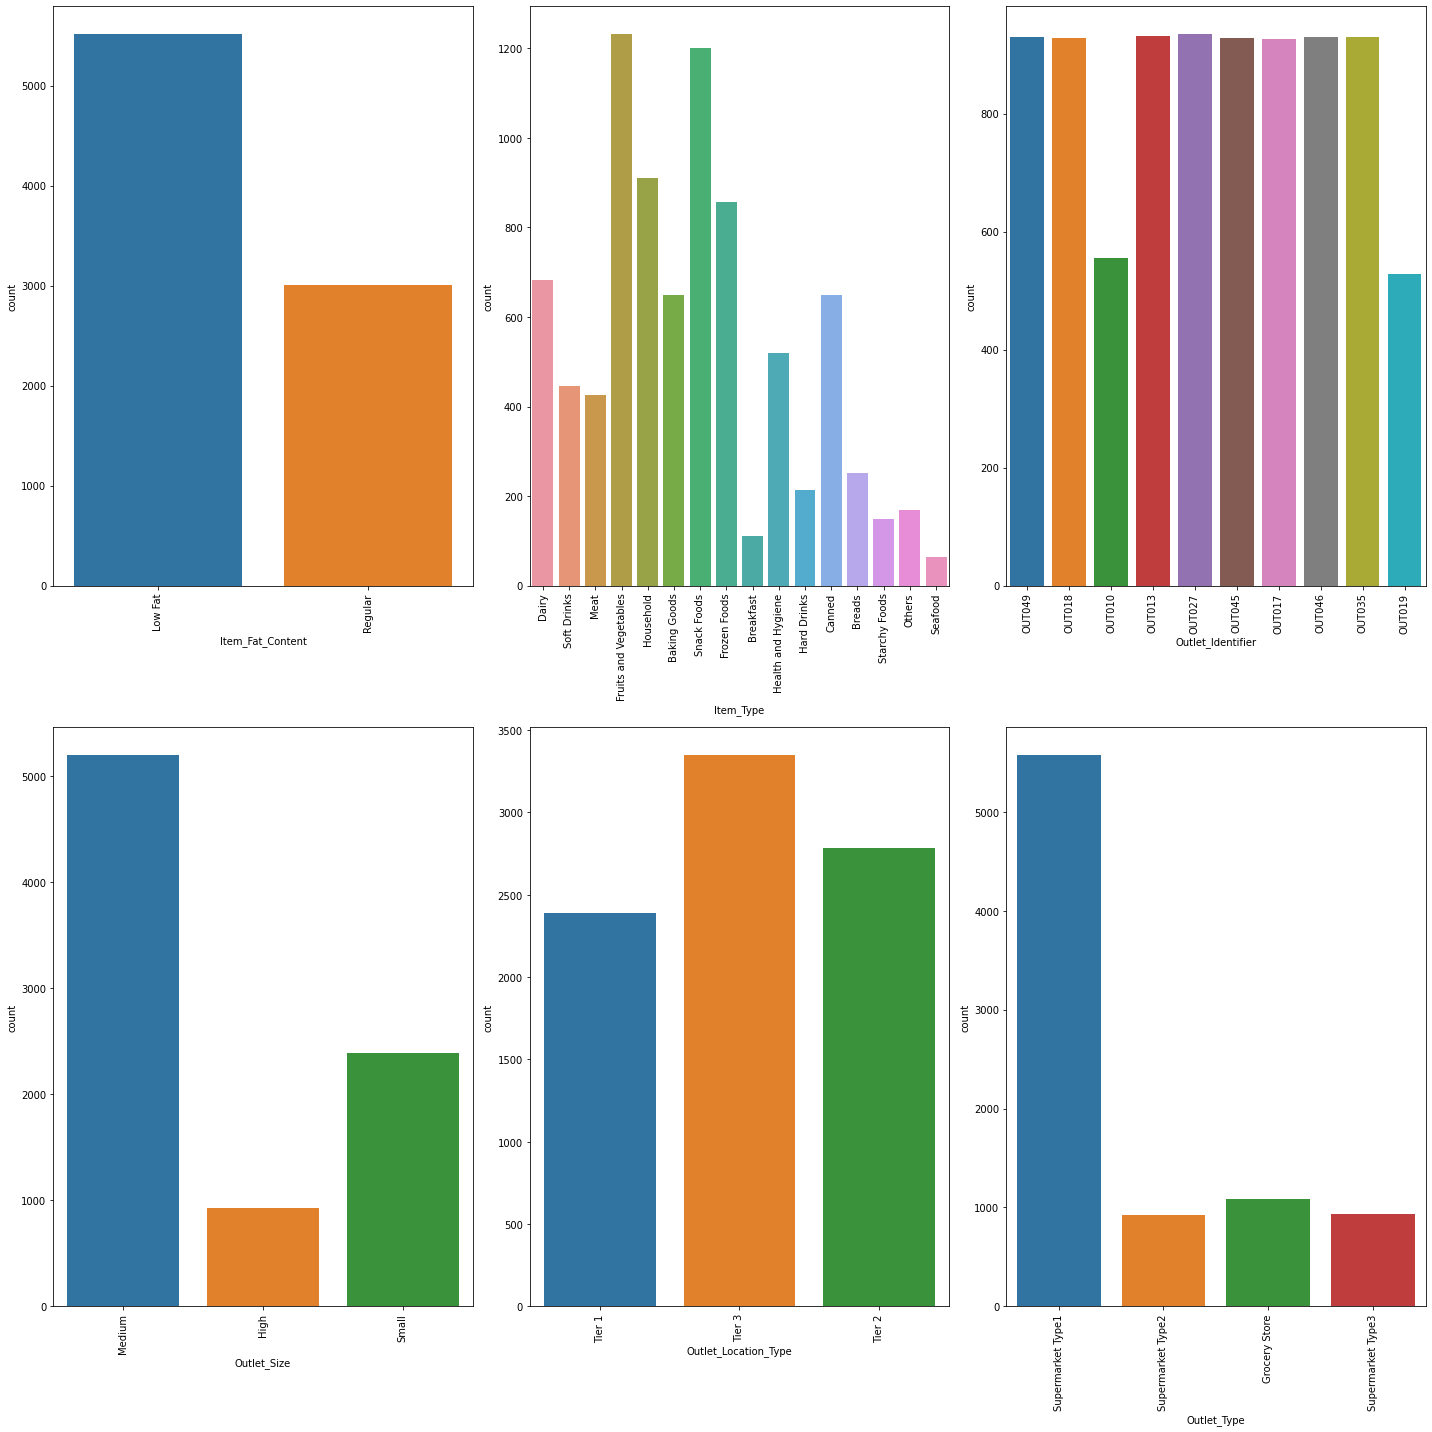

In [24]:
#Visualizations of categorical columns
figure = plt.figure(figsize=(20,20))
for index in range(1, len(categoricalCol)): #Skipping the first column 'Item_Identifier' since it has too many entires for a proper countplot
    plt.subplot(2,3, index)
    sns.countplot(bigMartDf[categoricalCol[index]])
    plt.xticks(rotation = 90)
    plt.tight_layout()

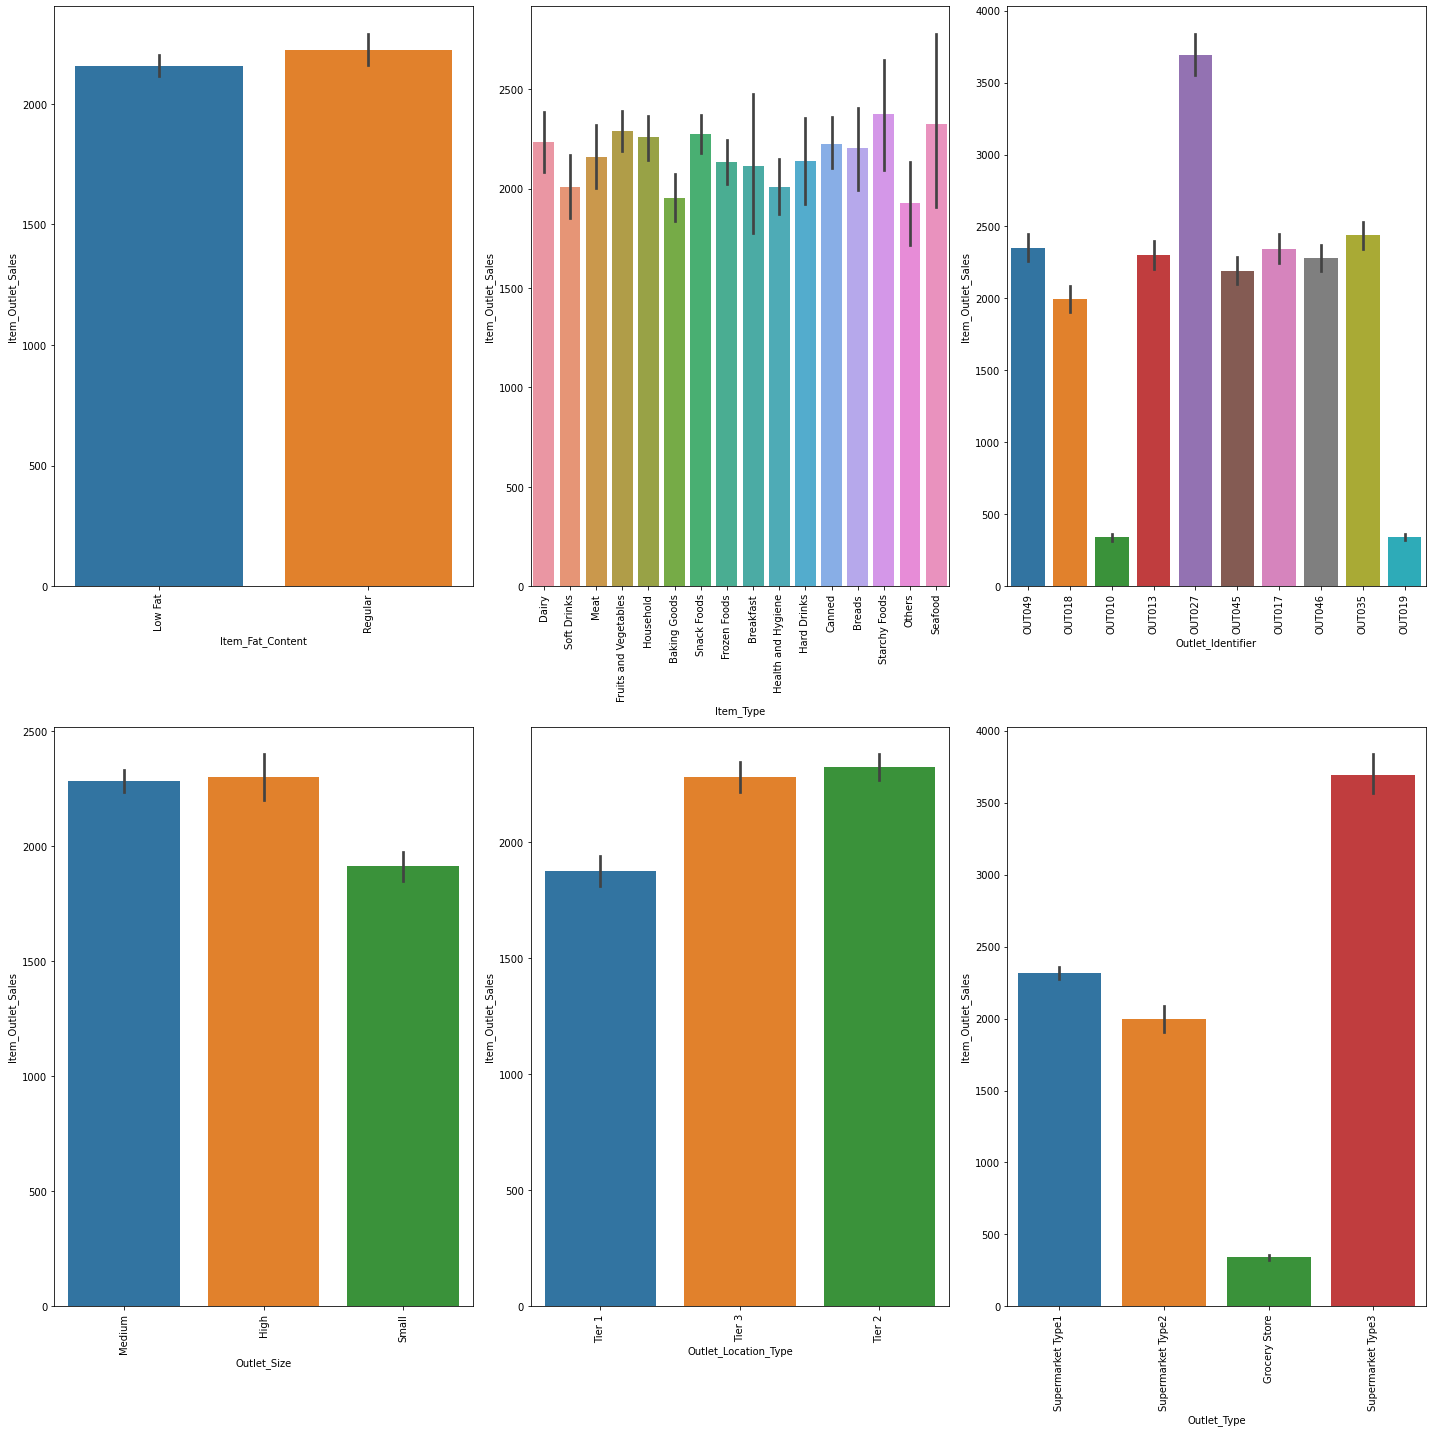

In [25]:
figure = plt.figure(figsize=(20,20))
for index in range(1, len(categoricalCol)): #Skipping the first column 'Item_Identifier' since it has too many entires for a proper countplot
    plt.subplot(2,3, index)
    sns.barplot(bigMartDf[categoricalCol[index]], y=bigMartDf['Item_Outlet_Sales'])
    plt.xticks(rotation = 90)
    plt.tight_layout()

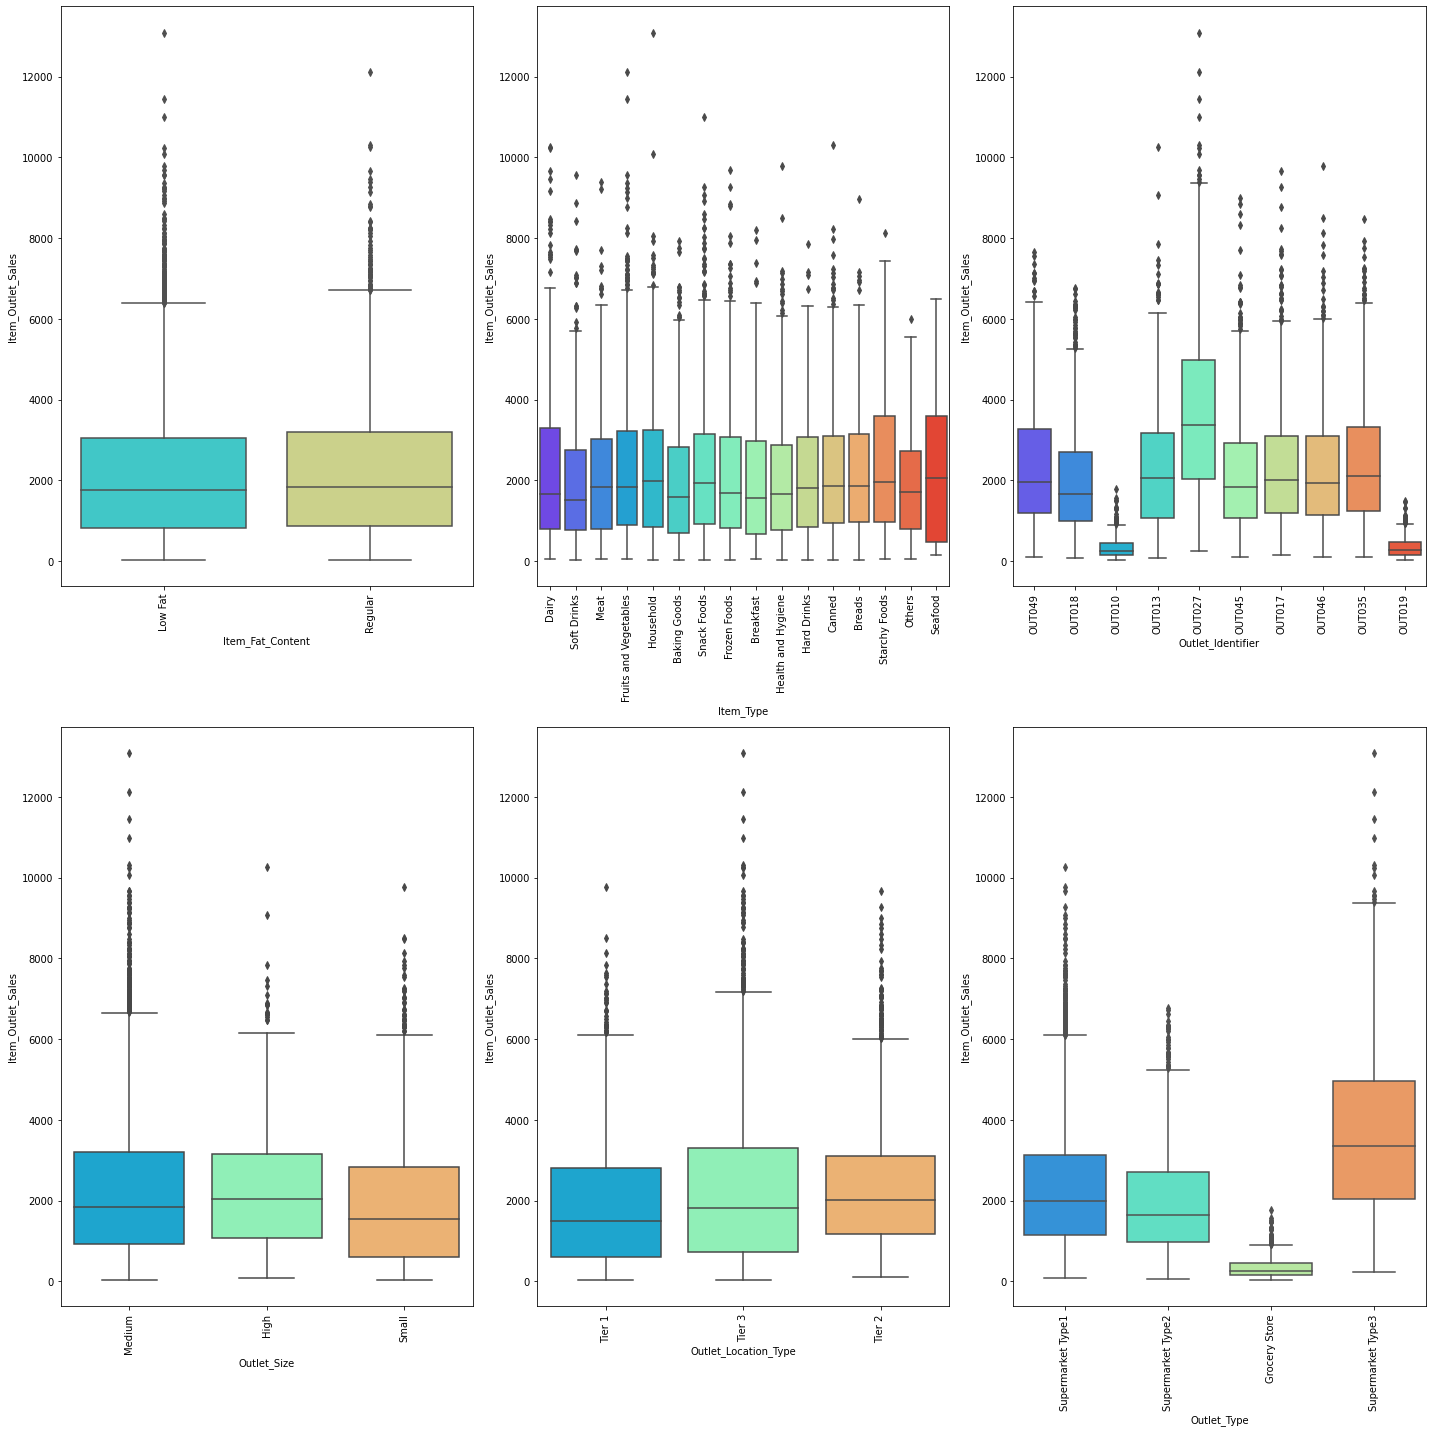

In [26]:
figure = plt.figure(figsize=(20,20))
for index in range(1, len(categoricalCol)): #Skipping the first column 'Item_Identifier' since it has too many entires for a proper countplot
    plt.subplot(2,3, index)
    sns.boxplot(bigMartDf[categoricalCol[index]], y=bigMartDf['Item_Outlet_Sales'], palette='rainbow')
    plt.xticks(rotation = 90)
    plt.tight_layout()

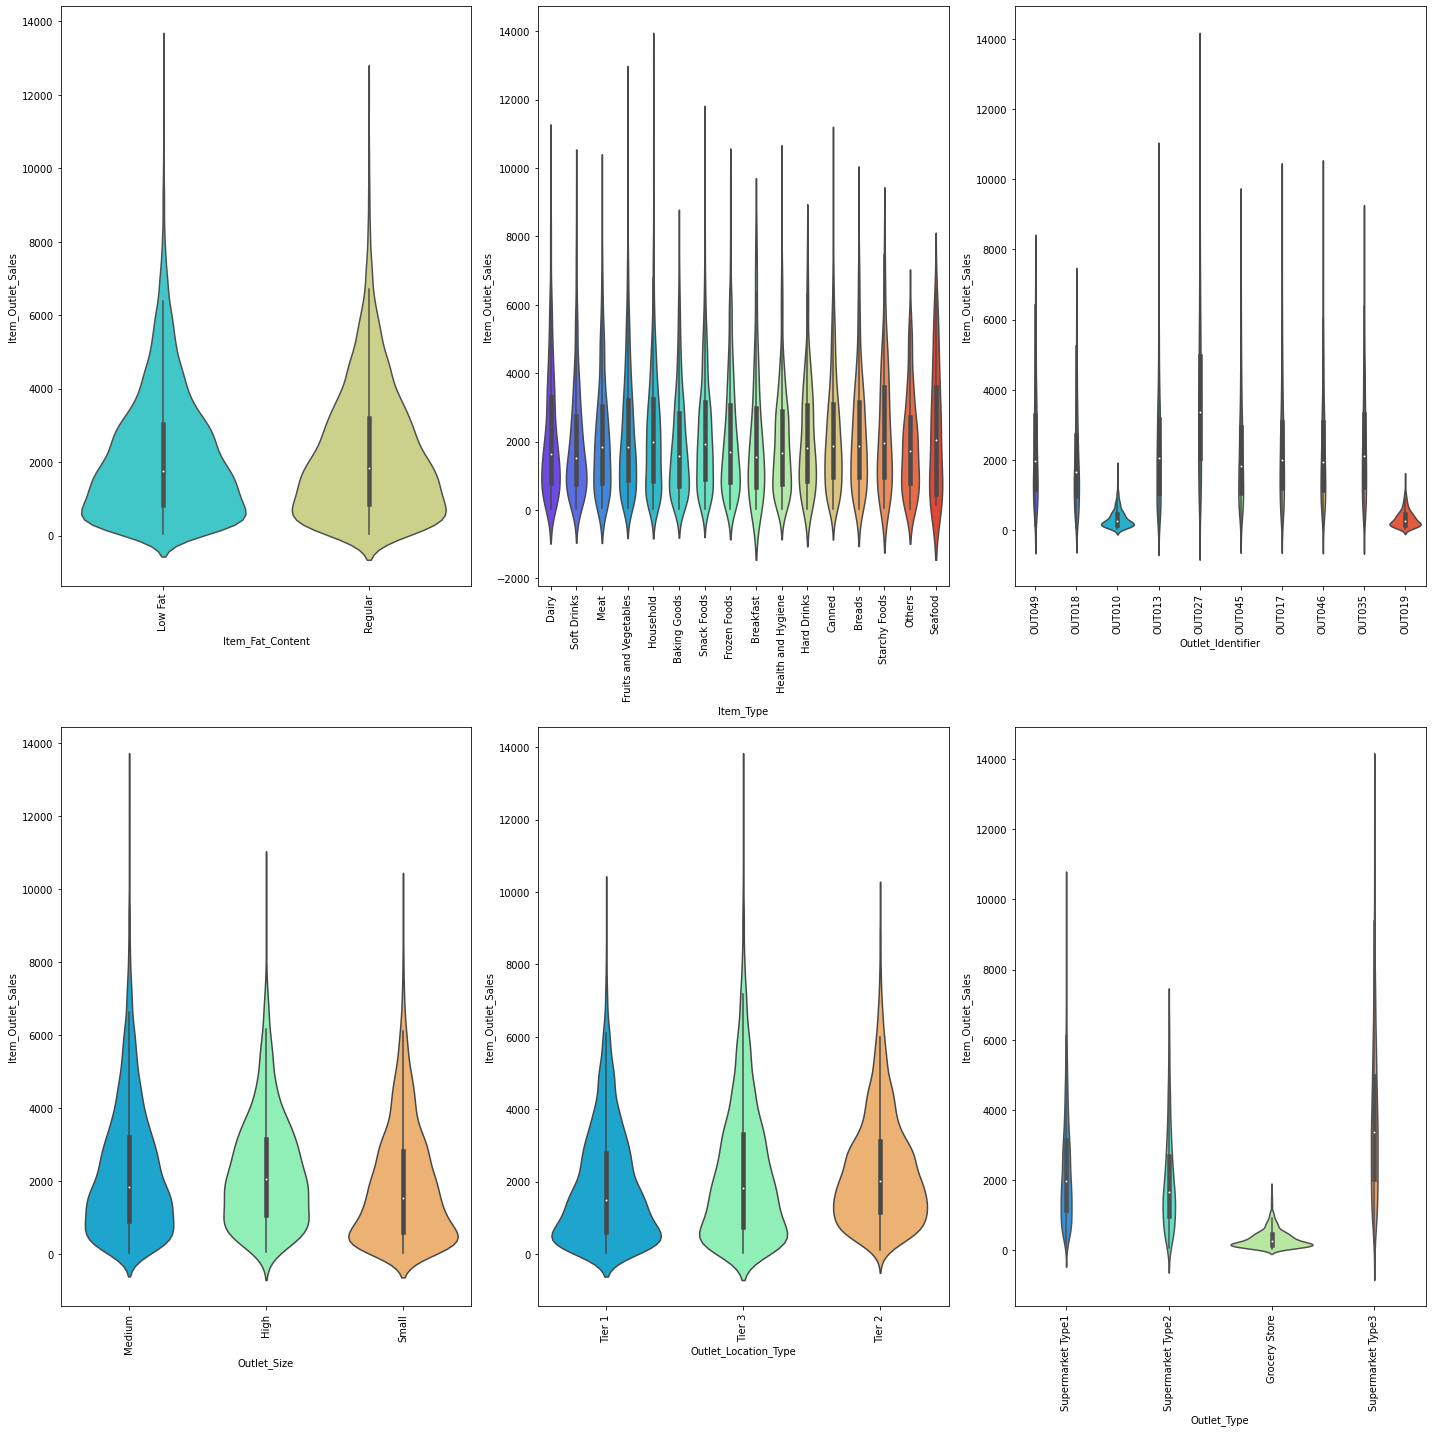

In [27]:
figure = plt.figure(figsize=(20,20))
for index in range(1, len(categoricalCol)): #Skipping the first column 'Item_Identifier' since it has too many entires for a proper countplot
    plt.subplot(2,3, index)
    sns.violinplot(bigMartDf[categoricalCol[index]], y=bigMartDf['Item_Outlet_Sales'], palette='rainbow')
    plt.xticks(rotation = 90)
    plt.tight_layout()

In [28]:
#Making a list of numerical columns
numericCol = list(bigMartDf.drop(categoricalCol, axis=1).columns)[:4]
numericCol

['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']

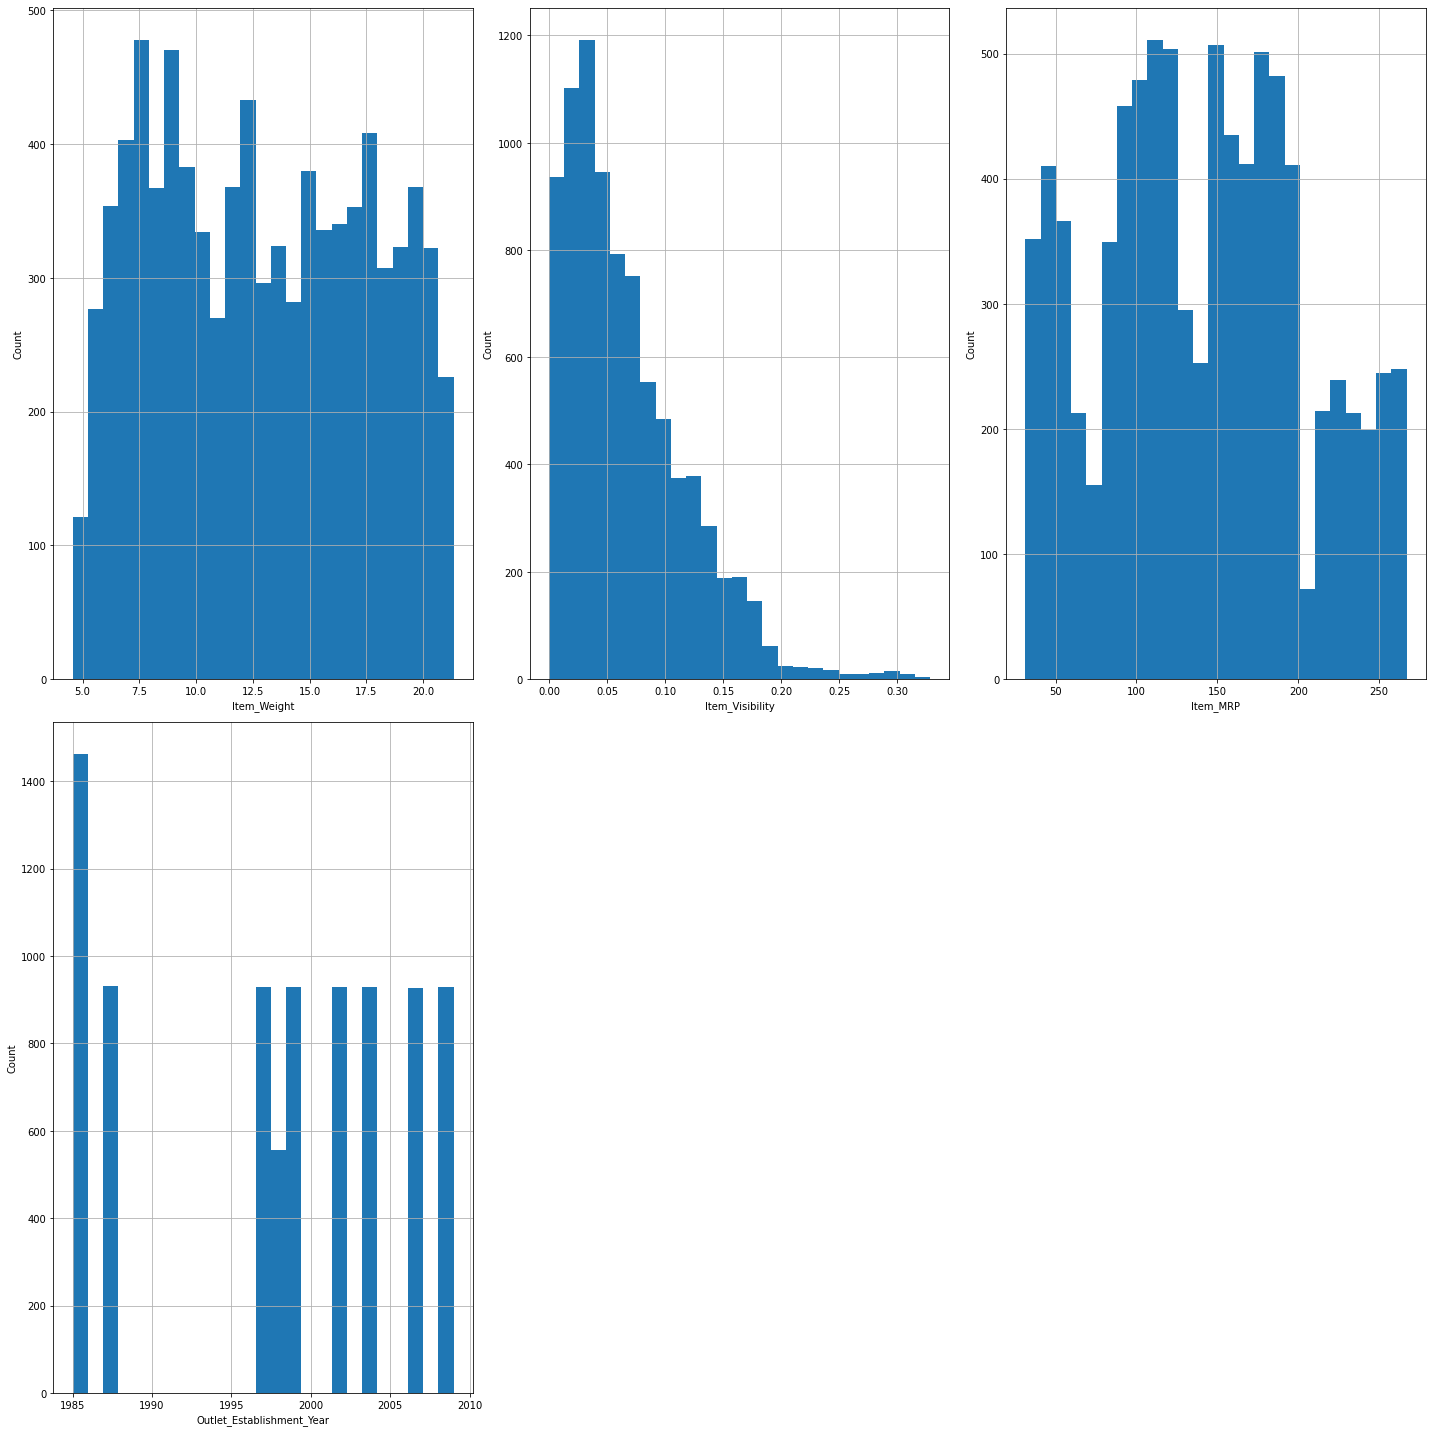

In [104]:
#Visualizations of categorical columns
figure = plt.figure(figsize=(20,20))
for index in range(len(numericCol)):
    plt.subplot(2,3, index+1)
    bigMartDf[numericCol[index]].hist(bins=25)
    plt.xlabel(numericCol[index])
    plt.ylabel('Count')
    plt.tight_layout()
plt.show()

In [29]:
#Checking the summary statistics
bigMartDf.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.875314,0.066132,140.992782,1997.831867,2181.288914
std,4.645010,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.785000,0.026989,93.826500,1987.000000,834.247400
50%,12.650000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [30]:
#Checking for skewness in the numeric columns
bigMartDf[numericCol].skew()

Item_Weight                  0.070400
Item_Visibility              1.167091
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
dtype: float64

In [31]:
#Applying column tranformation to remove skewness in Item_Visibility
bigMartDf['Item_Visibility'] = (bigMartDf['Item_Visibility'])**(1/2)

In [32]:
bigMartDf[numericCol].skew()

Item_Weight                  0.070400
Item_Visibility             -0.098056
Item_MRP                     0.127202
Outlet_Establishment_Year   -0.396641
dtype: float64

In [33]:
#Splitting x and y
x = bigMartDf.drop('Item_Outlet_Sales', axis = 1)
y = bigMartDf.Item_Outlet_Sales

In [34]:
#using make_column_transformer to perform one hot encoding in the categorical columns and minmax scaler in the numeric columns
colTrans = make_column_transformer((OneHotEncoder(), categoricalCol),
                                   (MinMaxScaler(), numericCol),
                                   remainder='passthrough', sparse_threshold=0)
x = colTrans.fit_transform(x)

In [36]:
#Splitting into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)

In [42]:
#Checking various regression algorithms
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
predR = rfr.predict(x_test)
r2_score(y_test, predR)

0.5511908318227376

In [45]:
from sklearn.linear_model import SGDRegressor
sdg = SGDRegressor()
sdg.fit(x_train, y_train)
predSdg = sdg.predict(x_test)
r2_score(y_test, predSdg)

0.5484000183252631

In [54]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(alpha = 0.00001, max_iter = 500)
mlp.fit(x_train, y_train)
predM = mlp.predict(x_test)
r2_score(y_test, predM)

0.5022877431383701

In [55]:
from sklearn.ensemble import AdaBoostRegressor
ada = AdaBoostRegressor()
ada.fit(x_train, y_train)
predAda = ada.predict(x_test)
r2_score(y_test, predAda)

0.4878447974048187

###### Cross Validation

In [57]:
cvrfr = cross_val_score(rfr, x, y, cv = 5, scoring='r2')
print(f'CV Score for RandomForestRegressor: {cvrfr.mean()}')

CV Score for RandomForestRegressor: 0.5519236640323122


In [58]:
cvsdg = cross_val_score(sdg, x, y, cv = 5, scoring='r2')
print(f'CV Score for SGDRegressor: {cvsdg.mean()}')

CV Score for RandomForestRegressor: 0.541701493200541


In [59]:
cvmlp = cross_val_score(mlp, x, y, cv = 5, scoring='r2')
print(f'CV Score for MLPRegressor: {cvmlp.mean()}')

CV Score for RandomForestRegressor: 0.4845470999116771


In [60]:
cvada = cross_val_score(ada, x, y, cv = 5, scoring='r2')
print(f'CV Score for AdaBoostRegressor: {cvada.mean()}')

CV Score for RandomForestRegressor: 0.3317900741433121


###### Hyper Parameter Tuning

In [65]:
from sklearn.model_selection import GridSearchCV
parameters = {'criterion' : ['mse', 'mae'],
             'max_depth': np.arange(2, 15),
             'n_estimators' : [10, 50, 75, 150, 300, 600]}

gs = GridSearchCV(rfr, parameters, cv=5, scoring = 'r2')

In [ ]:
gs.fit(x_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
rfr = RandomForestRegressor(criterion = 'mse', max_depth = 10, n_estimators = 150)
rfr.fit(x_train, y_train)
predRfr = rfr.predict(x_test)
r2_score(y_test, predRfr)

###### Saving the model

In [ ]:
import joblib
joblib.dump(rfr, 'bigmart.pkl')
#Checking the model
model = joblib.load('bigmart.pkl')
model.predict(x_test)